# PyTorch Image Classification Example

Now we'll be looking at how covalent can be used to run actual workflows on different hardwares without making a single line change in the core code.

This example is inspired from PyTorch's CIFAR10 Image Classfication tutorial which can be found [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). Some small changes have been made, things like organizing certain parts into functions and paramterizing them, etc, to covalentify the tutorial.

In [1]:
import covalent as ct

## Executors

Creating the executor objects we'll be using in this example:

1. DaskExecutor - Only requires the scheduler address of an already running Dask Cluster and every electron which has been assigned this executor will be run on that cluster.

2. SlurmExecutor - Requires minimal details so that it connects to the running SLURM cluster through `ssh` and executes the electron on the node given within the `options` parameter.

In [2]:
dask_executor = ct.executor.DaskExecutor(scheduler_address='tcp://127.0.0.1:55201')

slurm_executor = ct.executor.SlurmExecutor(
    username="sankalp",
    address="beehive.agnostiq.ai",
    remote_workdir="/federation/sankalp/workdir",
    ssh_key_file="/Users/sankalpsanand/.ssh/beehive",
    poll_freq=10,
    options={
        "partition": "compute", "ntasks": 1, "cpus-per-task": 32,
        "chdir": "/federation/sankalp/workdir", "nodelist": "beehive-compute-dy-c5a8xlarge-1"},
)


## Covalentify

The following transformation, data downloading, and dataloader objects have been enclosed in a parameterized function so they are more accessible throughout this example and can be used as we see fit.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

You'll notice we've added the `electron` decorator to these functions and unless they are called within a `lattice` and that `lattice` is dispatched, these will continue to act as normal functions.

In [4]:
@ct.electron
def get_transform(mean_tuple, std_tuple):
    """Return a normalized Tensor transform"""

    return transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=mean_tuple, std=std_tuple)])


@ct.electron
def get_dataset(train, transform, root):
    """Return a transformed CIFAR10 dataset"""

    return torchvision.datasets.CIFAR10(root=root, train=train,
                                        download=True, transform=transform)

@ct.electron
def get_dataloader(dataset, shuffle, batch_size):
    """Return the dataloader for given dataset"""

    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=shuffle)


@ct.electron
def get_test_accuracy(net, testloader):
    """Return accuracy of the trained network using the test dataset"""

    correct = 0
    total = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct // total

# Defining the classes present in the dataset
classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let's see how the dataset looks like:

Files already downloaded and verified


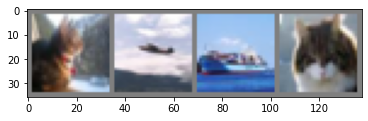

cat   plane ship  cat  


In [5]:
import matplotlib.pyplot as plt
import numpy as np

mean_tuple = (0.5, 0.5, 0.5)
std_tuple = (0.5, 0.5, 0.5)

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(get_dataloader(get_dataset(True, get_transform(mean_tuple, std_tuple), "./data"), True, 4))
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Again, here we've defined our network and put it in a function so that we can make any changes depending on parameters that might only be known during the time of execution. Once the new network has been created, we return the `Net` object.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

@ct.electron
def get_network(layers=1):
    """
    Return a network object with given specifications
    """

    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 5 * 5, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)
        

        def make_nn(self):
            return nn.Linear(84, 84)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            for _ in range(layers):
                x=F.relu(self.make_nn()(x))
            x = self.fc3(x)
            return x
    
    return Net()

## Training

Now that we've defined everything, it's time we put them together and begin with the training process.

You'll see that for the `training` function we are using the slurm executor so that we can leverage the already running high compute GPU SLURM cluster to train the classification model.

In [7]:
import torch.optim as optim

In [8]:

# @ct.electron(executor=slurm_executor)
@ct.electron
def training(trainloader, net, learning_rate, momentum, n_epochs):
    """
    Return a trained network with cross entropy loss and SGD optimizer with given parameters
    """

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
    
    return net

In [9]:
from pathlib import Path

data_path = str(Path("./data").absolute())

@ct.lattice(executor=dask_executor)
def workflow(batch_size, learning_rate, momentum, n_epochs,layers):
    """
    Stitching everything together in a workflow lattice
    """
    
    transform = get_transform(mean_tuple=(0.5, 0.5, 0.5), std_tuple=(0.5, 0.5, 0.5))

    trainset = get_dataset(train=True, transform=transform, root=data_path)
    trainloader = get_dataloader(dataset=trainset, shuffle=True, batch_size=batch_size)

    testset = get_dataset(train=False, transform=transform, root=data_path)
    testloader = get_dataloader(dataset=testset, shuffle=False, batch_size=batch_size)

    test_accuracies = []
    for layer in layers:
        net = get_network(layers=layer)

        training_result = training(
            trainloader=trainloader,
            net=net,
            learning_rate=learning_rate,
            momentum=momentum,
            n_epochs=n_epochs,
            )
        
        accuracy = get_test_accuracy(net=training_result, testloader=testloader)
        
        test_accuracies.append(accuracy)

    return test_accuracies


Now, let's dispatch the workflow.

In [10]:
dispatch_id = ct.dispatch(workflow)(batch_size=4, learning_rate=0.001, momentum=0.9, n_epochs=2, layers=range(5))
print(dispatch_id)

086b637b-8d0a-4d1b-afa8-2451167ddaa5


## Getting the results

We can get the complete `Result` object which contains all the information about the workflow.

In [11]:
workflow_result = ct.get_result(dispatch_id)
print(workflow_result)


Lattice Result
status: NEW_OBJECT
result: None
inputs: {'args': [], 'kwargs': {'batch_size': 4, 'learning_rate': 0.001, 'momentum': 0.9, 'n_epochs': 2, 'layers': range(0, 5)}}
error: None

start_time: None
end_time: None

results_dir: /Users/sankalpsanand/dev/tutorials_covalent_mlops_2022/results
dispatch_id: 086b637b-8d0a-4d1b-afa8-2451167ddaa5

Node Outputs
------------
get_transform(0): None
:parameter:(0.5, 0.5, 0.5)(1): None
:parameter:(0.5, 0.5, 0.5)(2): None
get_dataset(3): None
:parameter:True(4): None
:parameter:/Users/sankalpsanand/dev/tutorials_covalent_mlops_2022/data(5): None
get_dataloader(6): None
:parameter:True(7): None
:parameter:4(8): None
get_dataset(9): None
:parameter:False(10): None
:parameter:/Users/sankalpsanand/dev/tutorials_covalent_mlops_2022/data(11): None
get_dataloader(12): None
:parameter:False(13): None
:parameter:4(14): None
get_network(15): None
:parameter:0(16): None
training(17): None
:parameter:0.001(18): None
:parameter:0.9(19): None
:parameter:2

Now let's see what the accuracies were in each case of adding layers.

In [12]:
for i in range(5):
    print(f"Test Accuracy for network with {i} added layers: {workflow_result.result[i]}%")

TypeError: 'NoneType' object is not subscriptable

Let's see what the gound truth looks like for some of the images in the test dataset.

Files already downloaded and verified


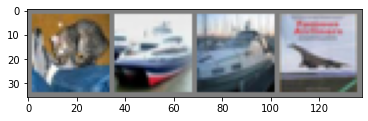

GroundTruth:  cat   ship  ship  plane


In [ ]:
testset = get_dataset(False, get_transform((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), data_path)
testloader = get_dataloader(testset, False, 4)

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## Accessing output of a particular trained network

Let's say we want the network which gave us the best accuracy, we can access it (and any other network as well) easily through the `workflow_result` object.

In [ ]:
net = workflow_result._get_node_output(node_id=17)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  frog  ship  truck plane


As we can see, it was about 50% right. Now let's see how did the network perform on a per-class basis.

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 72.0 %
Accuracy for class: car   is 55.7 %
Accuracy for class: bird  is 53.4 %
Accuracy for class: cat   is 36.6 %
Accuracy for class: deer  is 44.8 %
Accuracy for class: dog   is 46.0 %
Accuracy for class: frog  is 49.0 %
Accuracy for class: horse is 58.3 %
Accuracy for class: ship  is 61.8 %
Accuracy for class: truck is 58.8 %


'8255f267-4d32-493b-ba7e-f72a4a4a943c'